In [ ]:
   import os
import json
import math
import sys

import torch
import torch.nn as nn
import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, datasets
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

from model_8 import resnetv1
from my_dataset import MyDataSet
from utils import read_split_data, train_one_epoch, evaluate



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))
# tb_writer = SummaryWriter()
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    "val": transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}
train_images_path, train_images_label, val_images_path, val_images_label = read_split_data("./TsinghuaDog")

# 实例化训练数据集
train_dataset = MyDataSet(images_path=train_images_path,
                          images_class=train_images_label,
                          transform=data_transform["train"])

# 实例化验证数据集
val_dataset = MyDataSet(images_path=val_images_path,
                        images_class=val_images_label,
                        transform=data_transform["val"])
batch_size = 16
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=nw,
                                           collate_fn=train_dataset.collate_fn)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=nw,
                                         collate_fn=val_dataset.collate_fn)

model = resnetv1()
# load pretrain weights
# model_weight_path = "./resnet50-raydon.pth"
# model.load_state_dict(torch.load(model_weight_path, map_location=device))

model.to(device)

epochs = 75
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1E-4)
# optimizer = optim.Adam(params, lr=0.0001)
lf = lambda x: ((1 + math.cos(x * math.pi / epochs)) / 2) * (1 - 0.01) + 0.01  # cosine
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
train_l=[]
train_a=[]
val_l=[]
val_a=[]

for epoch in range(epochs):
    train_loss, train_acc = train_one_epoch(model=model,
                                optimizer=optimizer,
                                data_loader=train_loader,
                                device=device,
                                epoch=epoch)
    train_l.append(train_loss)
    train_a.append(train_acc)
    
    scheduler.step()

    val_loss, val_acc = evaluate(model=model,
                   data_loader=val_loader,
                   device=device,
                   epoch=epoch)
    
    val_l.append(val_loss)
    val_a.append(val_acc)
#     tags = ["train_loss", "train_acc", "val_loss", "val_acc", "learning_rate"]
#     tb_writer.add_scalar(tags[0], train_loss, epoch)
#     tb_writer.add_scalar(tags[1], train_acc, epoch)
#     tb_writer.add_scalar(tags[2], val_loss, epoch)
#     tb_writer.add_scalar(tags[3], val_acc, epoch)
#     tb_writer.add_scalar(tags[4], optimizer.param_groups[0]["lr"], epoch)

    torch.save(model.state_dict(), "./models/model-{}.pth".format(epoch))
    with open("./train_loss.txt","a") as f:
        f.write(str(train_loss) + "\n")
    with open("./val_loss.txt","a") as f:
        f.write(str(val_loss) + "\n")
    with open("./train_acc.txt","a") as f:
        f.write(str(train_acc) + "\n")
    with open("./val_acc.txt","a") as f:
        f.write(str(val_acc) + "\n")

print('Finished Training')


fig = plt.figure(figsize = (7,5))       #figsize是图片的大小`
ax1 = fig.add_subplot(1, 1, 1) # ax1是子图的名字`
x = range(75)
y = train_l
pl.plot(x,y,'g-',label=u'Dense_Unet(block layer=5)')
# ‘’g‘’代表“green”,表示画出的曲线是绿色，“-”代表画的曲线是实线，可自行选择，label代表的是图例的名称，一般要在名称前面加一个u，如果名称是中文，会显示不出来，目前还不知道怎么解决。
pl.xlabel(u'iters')
pl.ylabel(u'train_loss')
plt.title('loss')
plt.savefig("./train_loss.jpg")
plt.show()



pl.plot(x,train_a,'g-',label=u'Dense_Unet(block layer=5)')
# ‘’g‘’代表“green”,表示画出的曲线是绿色，“-”代表画的曲线是实线，可自行选择，label代表的是图例的名称，一般要在名称前面加一个u，如果名称是中文，会显示不出来，目前还不知道怎么解决。
pl.xlabel(u'iters')
pl.ylabel(u'train_acc')
plt.title('acc')
plt.savefig("./train_acc.jpg")
plt.show()

pl.plot(x,val_a,'g-',label=u'Dense_Unet(block layer=5)')
# ‘’g‘’代表“green”,表示画出的曲线是绿色，“-”代表画的曲线是实线，可自行选择，label代表的是图例的名称，一般要在名称前面加一个u，如果名称是中文，会显示不出来，目前还不知道怎么解决。
pl.xlabel(u'iters')
pl.ylabel(u'val_a')
plt.title('acc')
plt.savefig("./val_acc.jpg")
plt.show()

pl.plot(x,val_l,'g-',label=u'Dense_Unet(block layer=5)')
# ‘’g‘’代表“green”,表示画出的曲线是绿色，“-”代表画的曲线是实线，可自行选择，label代表的是图例的名称，一般要在名称前面加一个u，如果名称是中文，会显示不出来，目前还不知道怎么解决。
pl.xlabel(u'iters')
pl.ylabel(u'val_l')
plt.title('loss')
plt.savefig("./val_loss.jpg")
plt.show()


using cpu device.
4000 images were found in the dataset.
3200 images for training.
800 images for validation.
Using 8 dataloader workers every process
[train epoch 20] loss: 0.905, acc: 0.688:   2%|▏         | 4/200 [00:07<05:13,  1.60s/it]

In [ ]:
   import os
import json
import math
import sys

import torch
import torch.nn as nn
import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, datasets
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

from model_8 import resnetv1
from my_dataset import MyDataSet
from utils import read_split_data, train_one_epoch, evaluate



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))
# tb_writer = SummaryWriter()
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    "val": transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}
train_images_path, train_images_label, val_images_path, val_images_label = read_split_data("./TsinghuaDog")

# 实例化训练数据集
train_dataset = MyDataSet(images_path=train_images_path,
                          images_class=train_images_label,
                          transform=data_transform["train"])

# 实例化验证数据集
val_dataset = MyDataSet(images_path=val_images_path,
                        images_class=val_images_label,
                        transform=data_transform["val"])
batch_size = 16
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=nw,
                                           collate_fn=train_dataset.collate_fn)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=nw,
                                         collate_fn=val_dataset.collate_fn)

model = resnetv1()
# load pretrain weights
model_weight_path = "./models/model-19.pth"
model.load_state_dict(torch.load(model_weight_path, map_location=device))

model.to(device)

epochs = 75
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1E-4)
# optimizer = optim.Adam(params, lr=0.0001)
lf = lambda x: ((1 + math.cos(x * math.pi / epochs)) / 2) * (1 - 0.01) + 0.01  # cosine
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
train_l=[]
train_a=[]
val_l=[]
val_a=[]

for epoch in range(20,epochs):
    train_loss, train_acc = train_one_epoch(model=model,
                                optimizer=optimizer,
                                data_loader=train_loader,
                                device=device,
                                epoch=epoch)
    train_l.append(train_loss)
    train_a.append(train_acc)
    
    scheduler.step()

    val_loss, val_acc = evaluate(model=model,
                   data_loader=val_loader,
                   device=device,
                   epoch=epoch)
    
    val_l.append(val_loss)
    val_a.append(val_acc)
#     tags = ["train_loss", "train_acc", "val_loss", "val_acc", "learning_rate"]
#     tb_writer.add_scalar(tags[0], train_loss, epoch)
#     tb_writer.add_scalar(tags[1], train_acc, epoch)
#     tb_writer.add_scalar(tags[2], val_loss, epoch)
#     tb_writer.add_scalar(tags[3], val_acc, epoch)
#     tb_writer.add_scalar(tags[4], optimizer.param_groups[0]["lr"], epoch)

    torch.save(model.state_dict(), "./models/model-{}.pth".format(epoch))
    with open("./train_loss.txt","a") as f:
        f.write(str(train_loss) + "\n")
    with open("./val_loss.txt","a") as f:
        f.write(str(val_loss) + "\n")
    with open("./train_acc.txt","a") as f:
        f.write(str(train_acc) + "\n")
    with open("./val_acc.txt","a") as f:
        f.write(str(val_acc) + "\n")

print('Finished Training')


fig = plt.figure(figsize = (7,5))       #figsize是图片的大小`
ax1 = fig.add_subplot(1, 1, 1) # ax1是子图的名字`
x = range(75)
y = train_l
pl.plot(x,y,'g-',label=u'Dense_Unet(block layer=5)')
# ‘’g‘’代表“green”,表示画出的曲线是绿色，“-”代表画的曲线是实线，可自行选择，label代表的是图例的名称，一般要在名称前面加一个u，如果名称是中文，会显示不出来，目前还不知道怎么解决。
pl.xlabel(u'iters')
pl.ylabel(u'train_loss')
plt.title('loss')
plt.savefig("./train_loss.jpg")
plt.show()



pl.plot(x,train_a,'g-',label=u'Dense_Unet(block layer=5)')
# ‘’g‘’代表“green”,表示画出的曲线是绿色，“-”代表画的曲线是实线，可自行选择，label代表的是图例的名称，一般要在名称前面加一个u，如果名称是中文，会显示不出来，目前还不知道怎么解决。
pl.xlabel(u'iters')
pl.ylabel(u'train_acc')
plt.title('acc')
plt.savefig("./train_acc.jpg")
plt.show()

pl.plot(x,val_a,'g-',label=u'Dense_Unet(block layer=5)')
# ‘’g‘’代表“green”,表示画出的曲线是绿色，“-”代表画的曲线是实线，可自行选择，label代表的是图例的名称，一般要在名称前面加一个u，如果名称是中文，会显示不出来，目前还不知道怎么解决。
pl.xlabel(u'iters')
pl.ylabel(u'val_a')
plt.title('acc')
plt.savefig("./val_acc.jpg")
plt.show()

pl.plot(x,val_l,'g-',label=u'Dense_Unet(block layer=5)')
# ‘’g‘’代表“green”,表示画出的曲线是绿色，“-”代表画的曲线是实线，可自行选择，label代表的是图例的名称，一般要在名称前面加一个u，如果名称是中文，会显示不出来，目前还不知道怎么解决。
pl.xlabel(u'iters')
pl.ylabel(u'val_l')
plt.title('loss')
plt.savefig("./val_loss.jpg")
plt.show()


using cpu device.
4000 images were found in the dataset.
3200 images for training.
800 images for validation.
Using 8 dataloader workers every process
[train epoch 62] loss: 0.450, acc: 0.831:  65%|██████▌   | 130/200 [03:20<01:46,  1.52s/it]

In [1]:
   import os
import json
import math
import sys

import torch
import torch.nn as nn
import torch.optim as optim
# from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, datasets
import torch.optim.lr_scheduler as lr_scheduler
from tqdm import tqdm

from model_8 import resnetv1
from my_dataset import MyDataSet
from utils import read_split_data, train_one_epoch, evaluate



device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))
# tb_writer = SummaryWriter()
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    "val": transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}
train_images_path, train_images_label, val_images_path, val_images_label = read_split_data("./TsinghuaDog")

# 实例化训练数据集
train_dataset = MyDataSet(images_path=train_images_path,
                          images_class=train_images_label,
                          transform=data_transform["train"])

# 实例化验证数据集
val_dataset = MyDataSet(images_path=val_images_path,
                        images_class=val_images_label,
                        transform=data_transform["val"])
batch_size = 16
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           pin_memory=True,
                                           num_workers=nw,
                                           collate_fn=train_dataset.collate_fn)

val_loader = torch.utils.data.DataLoader(val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         pin_memory=True,
                                         num_workers=nw,
                                         collate_fn=val_dataset.collate_fn)

model = resnetv1()
# load pretrain weights
model_weight_path = "./models/model-61.pth"
model.load_state_dict(torch.load(model_weight_path, map_location=device))

model.to(device)

epochs = 75
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=1E-4)
# optimizer = optim.Adam(params, lr=0.0001)
lf = lambda x: ((1 + math.cos(x * math.pi / epochs)) / 2) * (1 - 0.01) + 0.01  # cosine
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
train_l=[]
train_a=[]
val_l=[]
val_a=[]

for epoch in range(62,epochs):
    train_loss, train_acc = train_one_epoch(model=model,
                                optimizer=optimizer,
                                data_loader=train_loader,
                                device=device,
                                epoch=epoch)
    train_l.append(train_loss)
    train_a.append(train_acc)
    
    scheduler.step()

    val_loss, val_acc = evaluate(model=model,
                   data_loader=val_loader,
                   device=device,
                   epoch=epoch)
    
    val_l.append(val_loss)
    val_a.append(val_acc)
#     tags = ["train_loss", "train_acc", "val_loss", "val_acc", "learning_rate"]
#     tb_writer.add_scalar(tags[0], train_loss, epoch)
#     tb_writer.add_scalar(tags[1], train_acc, epoch)
#     tb_writer.add_scalar(tags[2], val_loss, epoch)
#     tb_writer.add_scalar(tags[3], val_acc, epoch)
#     tb_writer.add_scalar(tags[4], optimizer.param_groups[0]["lr"], epoch)

    torch.save(model.state_dict(), "./models/model-{}.pth".format(epoch))
    with open("./train_loss.txt","a") as f:
        f.write(str(train_loss) + "\n")
    with open("./val_loss.txt","a") as f:
        f.write(str(val_loss) + "\n")
    with open("./train_acc.txt","a") as f:
        f.write(str(train_acc) + "\n")
    with open("./val_acc.txt","a") as f:
        f.write(str(val_acc) + "\n")

print('Finished Training')


fig = plt.figure(figsize = (7,5))       #figsize是图片的大小`
ax1 = fig.add_subplot(1, 1, 1) # ax1是子图的名字`
x = range(75)
y = train_l
pl.plot(x,y,'g-',label=u'Dense_Unet(block layer=5)')
# ‘’g‘’代表“green”,表示画出的曲线是绿色，“-”代表画的曲线是实线，可自行选择，label代表的是图例的名称，一般要在名称前面加一个u，如果名称是中文，会显示不出来，目前还不知道怎么解决。
pl.xlabel(u'iters')
pl.ylabel(u'train_loss')
plt.title('loss')
plt.savefig("./train_loss.jpg")
plt.show()



pl.plot(x,train_a,'g-',label=u'Dense_Unet(block layer=5)')
# ‘’g‘’代表“green”,表示画出的曲线是绿色，“-”代表画的曲线是实线，可自行选择，label代表的是图例的名称，一般要在名称前面加一个u，如果名称是中文，会显示不出来，目前还不知道怎么解决。
pl.xlabel(u'iters')
pl.ylabel(u'train_acc')
plt.title('acc')
plt.savefig("./train_acc.jpg")
plt.show()

pl.plot(x,val_a,'g-',label=u'Dense_Unet(block layer=5)')
# ‘’g‘’代表“green”,表示画出的曲线是绿色，“-”代表画的曲线是实线，可自行选择，label代表的是图例的名称，一般要在名称前面加一个u，如果名称是中文，会显示不出来，目前还不知道怎么解决。
pl.xlabel(u'iters')
pl.ylabel(u'val_a')
plt.title('acc')
plt.savefig("./val_acc.jpg")
plt.show()

pl.plot(x,val_l,'g-',label=u'Dense_Unet(block layer=5)')
# ‘’g‘’代表“green”,表示画出的曲线是绿色，“-”代表画的曲线是实线，可自行选择，label代表的是图例的名称，一般要在名称前面加一个u，如果名称是中文，会显示不出来，目前还不知道怎么解决。
pl.xlabel(u'iters')
pl.ylabel(u'val_l')
plt.title('loss')
plt.savefig("./val_loss.jpg")
plt.show()


using cpu device.
4000 images were found in the dataset.
3200 images for training.
800 images for validation.
Using 8 dataloader workers every process
[valid epoch 74] loss: 0.645, acc: 0.789: 100%|██████████| 50/50 [00:23<00:00,  2.12it/s]
Finished Training


NameError: name 'plt' is not defined

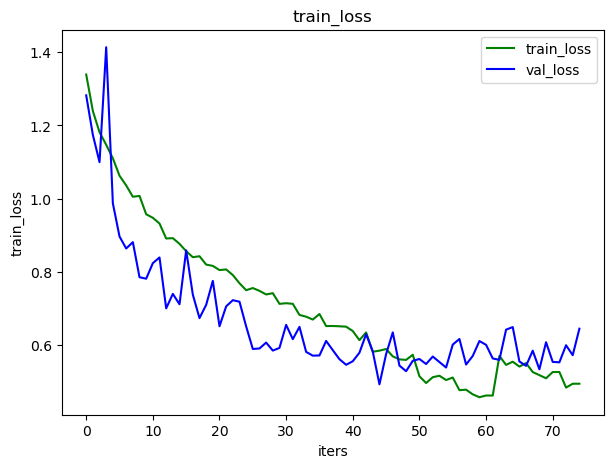

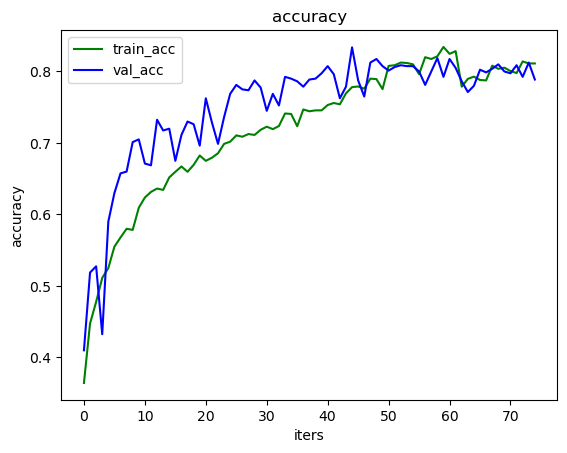

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
train_loss =np.loadtxt("./train_loss.txt")
train_acc =np.loadtxt("./train_acc.txt")
val_loss =np.loadtxt("./val_loss.txt")
val_acc =np.loadtxt("./val_acc.txt")

fig = plt.figure(figsize = (7,5))       #figsize是图片的大小`
ax1 = fig.add_subplot(1, 1, 1) # ax1是子图的名字`
x = range(75)

pl.plot(x,train_loss,'g-',label=u'train_loss')
# ‘’g‘’代表“green”,表示画出的曲线是绿色，“-”代表画的曲线是实线，可自行选择，label代表的是图例的名称，一般要在名称前面加一个u，如果名称是中文，会显示不出来，目前还不知道怎么解决。
pl.plot(x,val_loss,'b-',label=u'val_loss')
pl.xlabel(u'iters')
pl.ylabel(u'train_loss')
plt.title('train_loss')
plt.legend()
plt.savefig("./loss.jpg")
plt.show()

pl.plot(x,train_acc,'g-',label=u'train_acc')
# ‘’g‘’代表“green”,表示画出的曲线是绿色，“-”代表画的曲线是实线，可自行选择，label代表的是图例的名称，一般要在名称前面加一个u，如果名称是中文，会显示不出来，目前还不知道怎么解决。
pl.plot(x,val_acc,'b-',label=u'val_acc')
pl.xlabel(u'iters')
pl.ylabel(u'accuracy')
plt.title('accuracy')
plt.legend()
plt.savefig("./accuracy.jpg")
plt.show()


cpu
4000 images were found in the dataset.
3200 images for training.
800 images for validation.


100%|██████████| 50/50 [00:24<00:00,  2.02it/s]


[[151.  13.   3.   9.]
 [ 19. 175.   4.   5.]
 [ 20.   8. 176.  21.]
 [ 10.   4.  17. 165.]]


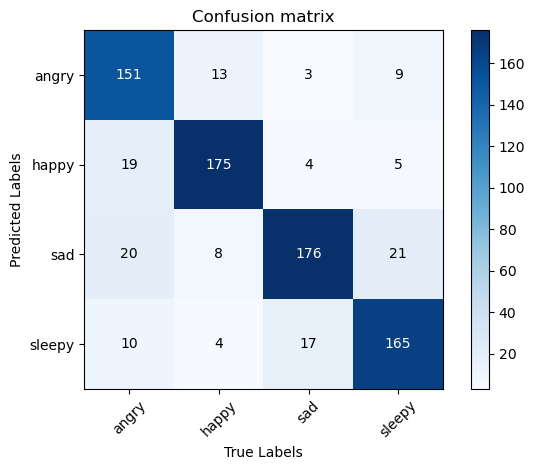

the model accuracy is  0.83375
+--------+-----------+--------------------+--------------------+--------------------+
|        | Precision |       Recall       |    Specificity     |         F1         |
+--------+-----------+--------------------+--------------------+--------------------+
| angry  |   0.858   |       0.755        | 0.9580000000000001 |       0.803        |
| happy  |   0.862   |       0.875        | 0.9530000000000001 |       0.868        |
|  sad   |   0.782   |        0.88        |       0.918        | 0.8280000000000001 |
| sleepy |   0.842   | 0.8250000000000001 | 0.9480000000000001 |       0.833        |
+--------+-----------+--------------------+--------------------+--------------------+


In [8]:
import os
import json

import torch
import torch.nn as nn
from torchvision import transforms, datasets
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from my_dataset import MyDataSet
from utils import read_split_data, train_one_epoch, evaluate
from model_8 import resnetv1 as resnet50


class ConfusionMatrix(object):
    """
    注意，如果显示的图像不全，是matplotlib版本问题
    本例程使用matplotlib-3.2.1(windows and ubuntu)绘制正常
    需要额外安装prettytable库
    """
    def __init__(self, num_classes: int, labels: list):
        self.matrix = np.zeros((num_classes, num_classes))
        self.num_classes = num_classes
        self.labels = labels

    def update(self, preds, labels):
        for p, t in zip(preds, labels):
            self.matrix[p, t] += 1

    def summary(self):
        # calculate accuracy
        sum_TP = 0
        for i in range(self.num_classes):
            sum_TP += self.matrix[i, i]
        acc = sum_TP / np.sum(self.matrix)
        print("the model accuracy is ", acc)

        # precision, recall, specificity
        table = PrettyTable()
        table.field_names = ["", "Precision", "Recall", "Specificity","F1"]
        for i in range(self.num_classes):
            TP = self.matrix[i, i]
            FP = np.sum(self.matrix[i, :]) - TP
            FN = np.sum(self.matrix[:, i]) - TP
            TN = np.sum(self.matrix) - TP - FP - FN
            Precision = round(TP / (TP + FP), 3) if TP + FP != 0 else 0.
            Recall = round(TP / (TP + FN), 3) if TP + FN != 0 else 0.
            Specificity = round(TN / (TN + FP), 3) if TN + FP != 0 else 0.
            F1 = round(2 * Precision * Recall / (Precision + Recall),3)
            table.add_row([self.labels[i], Precision, Recall, Specificity,F1])
        print(table)

    def plot(self):
        matrix = self.matrix
        print(matrix)
        plt.imshow(matrix, cmap=plt.cm.Blues)

        # 设置x轴坐标label
        plt.xticks(range(self.num_classes), self.labels, rotation=45)
        # 设置y轴坐标label
        plt.yticks(range(self.num_classes), self.labels)
        # 显示colorbar
        plt.colorbar()
        plt.xlabel('True Labels')
        plt.ylabel('Predicted Labels')
        plt.title('Confusion matrix')

        # 在图中标注数量/概率信息
        thresh = matrix.max() / 2
        for x in range(self.num_classes):
            for y in range(self.num_classes):
                # 注意这里的matrix[y, x]不是matrix[x, y]
                info = int(matrix[y, x])
                plt.text(x, y, info,
                         verticalalignment='center',
                         horizontalalignment='center',
                         color="white" if info > thresh else "black")
        plt.tight_layout()
        plt.show()


if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    train_images_path, train_images_label, val_images_path, val_images_label = read_split_data("./TsinghuaDog")
    data_transform = transforms.Compose([transforms.Resize(236),
                                         transforms.CenterCrop(224),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # data_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # get data root path
    # image_path = os.path.join(data_root, "data_set", "flower_data")  # flower data set path
    image_path = "./"
    assert os.path.exists(image_path), "data path {} does not exist.".format(image_path)

    val_dataset = MyDataSet(images_path=val_images_path,
                            images_class=val_images_label,
                            transform=data_transform)
    batch_size = 16
    nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])
    val_loader = torch.utils.data.DataLoader(val_dataset,
                                             batch_size=batch_size,
                                             shuffle=False,
                                             pin_memory=True,
                                             num_workers=nw,
                                             collate_fn=val_dataset.collate_fn)
    # validate_dataset = datasets.ImageFolder(root=os.path.join(image_path, "validation"),
    #                                         transform=data_transform)

    # batch_size = 16
    # validate_loader = torch.utils.data.DataLoader(validate_dataset,
    #                                               batch_size=batch_size, shuffle=False,
    #                                               num_workers=2)
    net = resnet50()
    # net.fc = nn.Linear(2048, 4)
    # load pretrain weights
    model_weight_path = "./models/model-44.pth"
    assert os.path.exists(model_weight_path), "cannot find {} file".format(model_weight_path)
    net.load_state_dict(torch.load(model_weight_path, map_location=device))
    net.to(device)

    # read class_indict
    json_label_path = './class_indices.json'
    assert os.path.exists(json_label_path), "cannot find {} file".format(json_label_path)
    json_file = open(json_label_path, 'r')
    class_indict = json.load(json_file)

    labels = [label for _, label in class_indict.items()]
    confusion = ConfusionMatrix(num_classes=4, labels=labels)
    net.eval()
    with torch.no_grad():
        for val_data in tqdm(val_loader):
            val_images, val_labels = val_data
            outputs = net(val_images.to(device))
            outputs = torch.softmax(outputs, dim=1)
            outputs = torch.argmax(outputs, dim=1)
            confusion.update(outputs.to("cpu").numpy(), val_labels.to("cpu").numpy())
    confusion.plot()
    confusion.summary()

